# Modelling 

In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbs
import geopandas as gpd
import folium 
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType


In [3]:
# Create a spark session with increased memory allocation
spark = (
    SparkSession.builder.appName("ADS Project1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Set the driver memory to 8GB
    .config("spark.executor.memory", "8g")  # Set the executor memory to 8GB
    .getOrCreate()
)

24/08/31 21:08:45 WARN Utils: Your hostname, Hanshis-Laptop.local resolves to a loopback address: 127.0.0.1; using 10.12.218.66 instead (on interface en0)
24/08/31 21:08:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/31 21:08:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/31 21:08:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/08/31 21:08:46 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/08/31 21:08:46 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


## Dataset

In [4]:
# import the data
spark.conf.set("spark.sql.parquet.compression.codec","gzip")

In [8]:
# Load the data
df = spark.read.parquet("../data/curated/merged_data/first_cleaned.parquet")

In [9]:
# Drop missing values
df = df.dropna()

In [10]:
# compare the % of rows before and after dropping missing values
print(f"Number of rows before dropping missing values: {df.count()}")
print(f"Number of rows after dropping missing values: {df.dropna().count()}")
print(f"Percentage of rows removed: {100*(1 - df.dropna().count()/df.count()):.2f}%")

Number of rows before dropping missing values: 23635
Number of rows after dropping missing values: 23635
Percentage of rows removed: 0.00%


## Feature selection

In [11]:
# List of columns to drop
columns_to_drop = [
    'VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag',
    'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 
    'tolls_amount', 'improvement_surcharge', 'total_amount', 
    'congestion_surcharge', 'ehail_fee', 'DOLocationID', 'DOBorough','dropoff_hour',
    'trip_distance', 'trip_duration'
]

# Dropping all specified columns at once in PySpark
df = df.drop(*columns_to_drop) 

In [12]:
# check the schema
df.printSchema()

root
 |-- pickup_date: date (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- PUBorough: string (nullable = true)
 |-- hourly_trip_count: long (nullable = true)
 |-- CIG: double (nullable = true)
 |-- WND: double (nullable = true)
 |-- VIS: double (nullable = true)
 |-- TMP: double (nullable = true)
 |-- DEW: double (nullable = true)
 |-- SLP: double (nullable = true)
 |-- Number of Events: long (nullable = true)



## Data split

In [13]:
from pyspark.sql.functions import col, month

# Filter the data by months for training, validation, and test sets
train_df = df.filter((month(col("pickup_date")).isin(7, 8, 9, 10)))
validation_df = df.filter((month(col("pickup_date")) == 11))
test_df = df.filter((month(col("pickup_date")) == 12))

In [14]:
train_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()

+-----------+-----------+---------+-----------------+---+---+---+---+---+---+----------------+
|pickup_date|pickup_hour|PUBorough|hourly_trip_count|CIG|WND|VIS|TMP|DEW|SLP|Number of Events|
+-----------+-----------+---------+-----------------+---+---+---+---+---+---+----------------+
|          0|          0|        0|                0|  0|  0|  0|  0|  0|  0|               0|
+-----------+-----------+---------+-----------------+---+---+---+---+---+---+----------------+



## Linear regression

In [15]:
# List of categorical and numerical columns
categorical_columns = ['PUBorough'] 
numerical_columns = [
    'pickup_hour', 
    'CIG', 'WND', 'VIS', 'TMP', 'DEW', 'SLP', 'Number of Events'
]

In [16]:
# Indexing and Encoding categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_ohe") for col in categorical_columns]

In [17]:
# Assemble the feature vector
assembler = VectorAssembler(
    inputCols=[
        'pickup_hour', 
        'CIG', 'WND', 'VIS', 'TMP', 'DEW', 'SLP', 'Number of Events',
        'PUBorough_ohe'
    ], 
    outputCol="features"
)


In [18]:
# Standardization
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")


In [19]:
# Linear Regression
lr = LinearRegression(featuresCol="scaled_features", labelCol="hourly_trip_count")

In [20]:
# Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, lr])

In [21]:
# Fit the model on the training set
model = pipeline.fit(train_df)

24/08/31 21:10:33 WARN Instrumentation: [9dbfd295] regParam is zero, which might cause numerical instability and overfitting.
24/08/31 21:10:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/31 21:10:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [22]:
# Mean hourly trip count
mean_hourly_trip_count = train_df.agg(F.mean("hourly_trip_count")).head()[0]
print(f"Mean hourly trip count: {mean_hourly_trip_count}")

Mean hourly trip count: 907.470203091846


In [23]:
# Evaluate the model on the validation set
validation_predictions = model.transform(validation_df)
evaluator = RegressionEvaluator(labelCol="hourly_trip_count", predictionCol="prediction", metricName="rmse")
validation_rmse = evaluator.evaluate(validation_predictions)
print(f"Root Mean Squared Error (RMSE) on validation data = {validation_rmse}")

Root Mean Squared Error (RMSE) on validation data = 1025.1518226038045


In [24]:
# If satisfied with validation performance, evaluate on the test set
test_predictions = model.transform(test_df)
test_rmse = evaluator.evaluate(test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {test_rmse}")

Root Mean Squared Error (RMSE) on test data = 1026.5531494839186


### Feature Analysis 

In [25]:
coefficients = model.stages[-1].coefficients

In [26]:
# List of features used
features = [
    'pickup_hour', 'CIG', 'WND', 'VIS', 'TMP', 'DEW', 'SLP', 'Number of Events', 'PUBorough_ohe'
]

# Combine features with their corresponding coefficients
feature_coefficients = [(features[i], float(coefficients[i])) for i in range(len(features))]

# Define schema explicitly
schema = StructType([
    StructField("Feature", StringType(), True),
    StructField("Coefficient", DoubleType(), True)
])

# Convert coefficients to a DataFrame with the specified schema
feature_coefficients_df = spark.createDataFrame(feature_coefficients, schema=schema)

# Show the coefficients sorted by their absolute value
feature_coefficients_df.orderBy(abs(feature_coefficients_df.Coefficient), ascending=False).show()


+----------------+-------------------+
|         Feature|        Coefficient|
+----------------+-------------------+
|     pickup_hour|  365.0723203456686|
|   PUBorough_ohe| 268.64552687163007|
|Number of Events| 181.99665080871705|
|             DEW| -64.17002425052067|
|             WND|-51.488168844165635|
|             TMP|  47.82495875395248|
|             CIG| -32.46554135660375|
|             SLP|  13.96495886105242|
|             VIS|  7.181506838283222|
+----------------+-------------------+



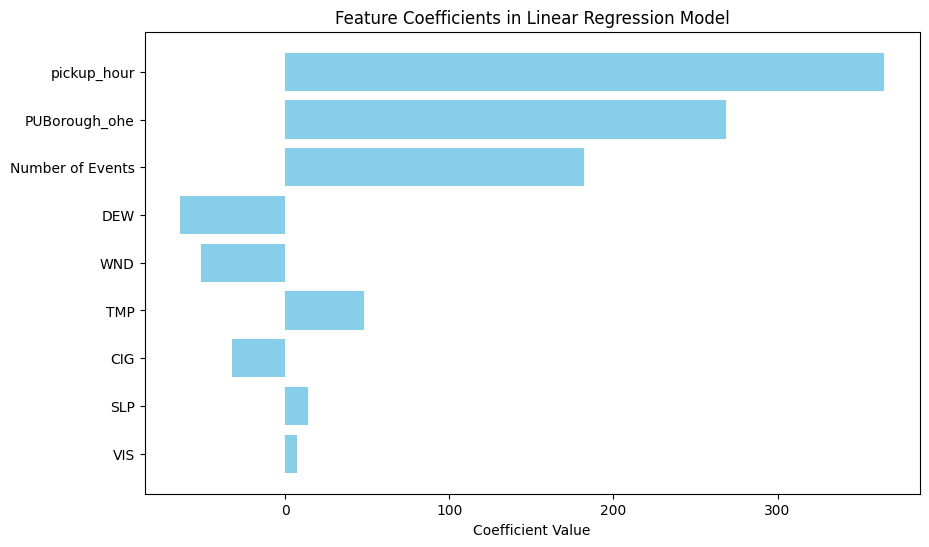

In [27]:
# Convert the PySpark DataFrame to a Pandas DataFrame for easier plotting
feature_coefficients_pd = feature_coefficients_df.toPandas()

# Sort the coefficients by their absolute value for better visualization
feature_coefficients_pd = feature_coefficients_pd.reindex(feature_coefficients_pd.Coefficient.abs().sort_values(ascending=False).index)

# Plot the feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(feature_coefficients_pd['Feature'], feature_coefficients_pd['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients in Linear Regression Model')
plt.gca().invert_yaxis()
plt.show()

## Gradient Boosting


In [28]:
# Gradient Boosted Trees Regressor
gbt = GBTRegressor(featuresCol="scaled_features", labelCol="hourly_trip_count", maxIter=100, maxDepth=5)

# Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, gbt])

# Fit the model on the training set
model = pipeline.fit(train_df)


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=44560Kb max_used=44560Kb free=86511Kb
 bounds [0x000000010b1e8000, 0x000000010dda8000, 0x00000001131e8000]
 total_blobs=16580 nmethods=14689 adapters=1802
 compilation: disabled (not enough contiguous free space left)


In [29]:
# Evaluate the model on the validation set
validation_predictions = model.transform(validation_df)
evaluator = RegressionEvaluator(labelCol="hourly_trip_count", predictionCol="prediction", metricName="rmse")
validation_rmse = evaluator.evaluate(validation_predictions)
print(f"Root Mean Squared Error (RMSE) on validation data = {validation_rmse}")

# If satisfied with validation performance, evaluate on the test set
test_predictions = model.transform(test_df)
test_rmse = evaluator.evaluate(test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {test_rmse}")

Root Mean Squared Error (RMSE) on validation data = 601.984166449256
Root Mean Squared Error (RMSE) on test data = 741.0730053646743


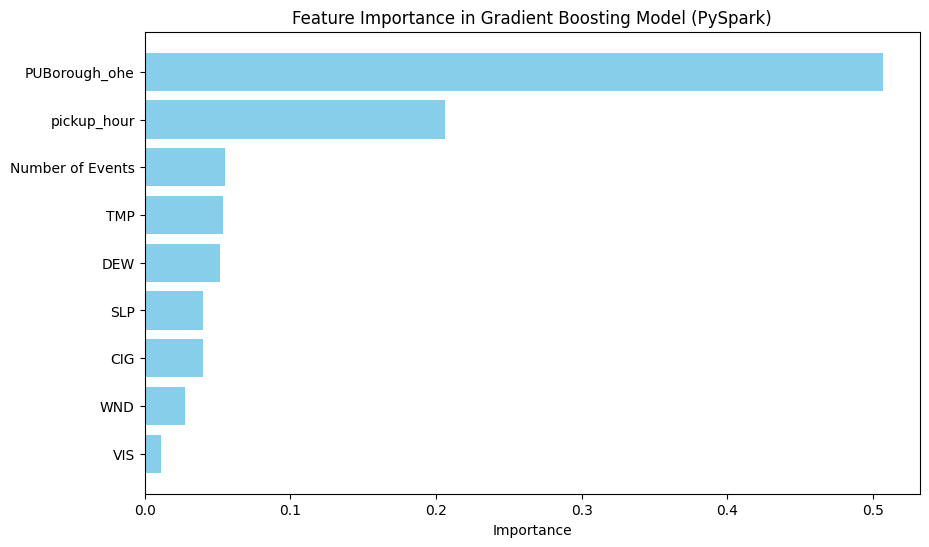

In [30]:
from pyspark.ml.linalg import DenseVector
import matplotlib.pyplot as plt
import pandas as pd

# Extract the GBT model from the pipeline
gbt_model = model.stages[-1]

# Get the feature importances from the GBT model
feature_importances = gbt_model.featureImportances

# Extract the input feature column names used in the assembler
input_feature_cols = assembler.getInputCols()

# Convert the SparseVector of feature importances to a list
importances = [(feature, float(importance)) for feature, importance in zip(input_feature_cols, feature_importances)]
importances = sorted(importances, key=lambda x: x[1], reverse=True)

# Convert to DataFrame for easier plotting
importance_df = pd.DataFrame(importances, columns=["Feature", "Importance"])

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Gradient Boosting Model (PySpark)')
plt.gca().invert_yaxis()
plt.show()